In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import FourierBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from joblib import Parallel, delayed
from tqdm import tqdm

C:\Users\sunwoong\AppData\Local\Temp\ipykernel_19704\1557460481.py:13: DeprecationWarning: The module "feature_extraction" is deprecated.Please use "dim_reduction" for FPCAor "feature_construction" for feature construction techniques
  from skfda.preprocessing.dim_reduction.feature_extraction import FPCA


In [2]:
data=pd.read_csv("levelups_panel_20240722.csv",encoding='utf-8')

In [3]:
data = data[data['level_to'] <= 100]

In [31]:
data[data['player_slug']=='2021-12-28T10:16:27.186Z']

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
1159574,2021-12-28T10:16:27.186Z,알로하루,178,1,1589500.0,0.0,216,complete,1,2,...,0.0,0.0,0.0,0.0,0.0,2021-12-28,2021-12-28,True,4.660556,0
1159575,2021-12-28T10:16:27.186Z,알로하루,178,1,1589500.0,0.0,216,complete,2,3,...,0.0,0.0,0.0,0.0,0.0,2021-12-28,2021-12-28,True,4.660556,0
1159576,2021-12-28T10:16:27.186Z,알로하루,178,1,1589500.0,0.0,216,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2021-12-28,2021-12-28,True,4.660556,0
1159577,2021-12-28T10:16:27.186Z,알로하루,178,1,1589500.0,0.0,216,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2021-12-28,2021-12-28,True,4.660556,0
1159578,2021-12-28T10:16:27.186Z,알로하루,178,1,1589500.0,0.0,216,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2021-12-28,2021-12-28,True,4.660556,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159668,2021-12-28T10:16:27.186Z,알로하루,178,1,1589500.0,0.0,216,complete,95,96,...,0.0,0.0,0.0,0.0,0.0,2021-12-28,2021-12-28,True,4.660556,0
1159669,2021-12-28T10:16:27.186Z,알로하루,178,1,1589500.0,0.0,216,complete,96,97,...,0.0,0.0,0.0,0.0,0.0,2021-12-28,2021-12-28,True,4.660556,0
1159670,2021-12-28T10:16:27.186Z,알로하루,178,1,1589500.0,0.0,216,complete,97,98,...,0.0,0.0,0.0,0.0,0.0,2021-12-28,2021-12-28,True,4.660556,0
1159671,2021-12-28T10:16:27.186Z,알로하루,178,1,1589500.0,0.0,216,complete,98,99,...,0.0,0.0,0.0,0.0,0.0,2021-12-28,2021-12-28,True,4.660556,0


In [4]:
data_ratio_term = data[['player_slug','binge', 'level_to', 'interval','total_purchase','total_ad']]

# 데이터 피벗
pivot_data_ratio = data_ratio_term.pivot_table(index='player_slug', columns='level_to', values='interval', aggfunc='mean')
binge_series = data.drop_duplicates('player_slug').set_index('player_slug')['total_purchase']
pivot_data_ratio = pivot_data_ratio.join(binge_series)

In [63]:
non_zero_ad_total_count = pivot_data_ratio[pivot_data_ratio['total_purchase'] != 0].shape[0]
non_zero_ad_total_count

3218

In [66]:
filtered_df = pivot_data_ratio.dropna(subset=pivot_data_ratio.columns[:100])
non_zero_ad_total_count = filtered_df[filtered_df['total_purchase'] != 0].shape[0]
non_zero_ad_total_count

1662

In [90]:
filtered_df

,2,3,4,5,6,7,8,9,10,11,...,92,93,94,95,96,97,98,99,100,total_purchase
player_slug,,,,,,,,,,,,,,,,,,,,,
2021-11-01T08:32:01.518Z,0.019444,0.004167,0.009444,0.015833,0.015278,0.020833,0.026667,0.034167,0.044722,0.059167,...,0.069722,0.063056,0.115556,0.152222,0.003333,0.003889,0.132667,0.906944,0.914500,0.0
2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,0.041667,...,0.045278,0.003889,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,0.0
2021-11-01T14:12:34.729Z,0.015833,0.004444,0.030278,0.013889,0.028056,0.020000,0.021389,0.026389,0.032778,0.041944,...,0.046111,0.051944,0.011667,0.064500,0.351111,0.041611,0.111389,0.002222,0.001944,0.0
2021-11-01T15:01:02.831Z,0.007778,0.003056,0.006389,0.009722,0.012500,0.049722,0.070833,0.036222,0.032500,0.042222,...,0.077222,0.003611,0.043944,0.236111,0.036111,0.002778,0.126667,0.121111,0.135556,0.0
2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,0.036667,...,0.035556,0.129722,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,3300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,0.047500,...,0.060889,0.048611,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,3300.0
2022-03-28T07:44:40.201Z,0.006944,0.003056,0.005833,0.012500,0.012500,0.021667,0.021389,0.027222,0.036944,0.037778,...,0.127722,0.096944,0.674444,0.759722,0.876389,0.136778,0.171667,0.043056,0.067500,0.0
2022-03-28T11:06:23.113Z,0.006389,0.005278,0.012222,0.021944,0.031389,0.026667,0.024722,0.033889,0.035556,0.050833,...,0.040778,0.032222,0.020278,0.081389,0.080000,0.002778,0.002778,0.071167,0.149722,122100.0


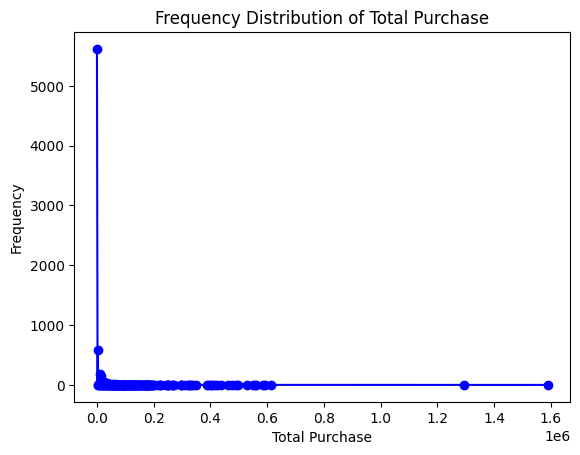

In [93]:
# total_purchase 값의 빈도수 계산
value_counts = filtered_df['total_purchase'].value_counts().sort_index()

# 빈도수를 선 그래프로 시각화
plt.plot(value_counts.index, value_counts.values, marker='o', linestyle='-', color='b')
plt.xlabel('Total Purchase')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Total Purchase')
plt.show()

In [23]:
# 각 컬럼별 null 값의 개수 계산
null_counts = pivot_data_ratio.isnull().sum()

# null 값의 개수를 데이터프레임으로 변환
null_counts_df = null_counts.to_frame('Null Count')

# null 값의 개수를 출력
print(null_counts_df)


                Null Count
2                        0
3                      704
4                     1371
5                     1901
6                     8438
...                    ...
97                   51256
98                   51414
99                   51734
100                  52063
total_purchase           0

[100 rows x 1 columns]


In [95]:
filtered_df = pivot_data_ratio.dropna(subset=pivot_data_ratio.columns[:100])
filtered_df.to_csv("full_lv50_0729.csv",encoding='utf-8')

In [7]:
non_zero_ad_total_count = pivot_data_ratio[pivot_data_ratio['total_purchase'] != 0]
filtered_df = non_zero_ad_total_count.dropna(subset=non_zero_ad_total_count.columns[:100])

In [9]:
filtered_df.to_csv("full_lv50_0729_no_zero.csv",encoding='utf-8')

In [96]:
filtered_df

,2,3,4,5,6,7,8,9,10,11,...,92,93,94,95,96,97,98,99,100,total_purchase
player_slug,,,,,,,,,,,,,,,,,,,,,
2021-11-01T08:32:01.518Z,0.019444,0.004167,0.009444,0.015833,0.015278,0.020833,0.026667,0.034167,0.044722,0.059167,...,0.069722,0.063056,0.115556,0.152222,0.003333,0.003889,0.132667,0.906944,0.914500,0.0
2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,0.041667,...,0.045278,0.003889,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,0.0
2021-11-01T14:12:34.729Z,0.015833,0.004444,0.030278,0.013889,0.028056,0.020000,0.021389,0.026389,0.032778,0.041944,...,0.046111,0.051944,0.011667,0.064500,0.351111,0.041611,0.111389,0.002222,0.001944,0.0
2021-11-01T15:01:02.831Z,0.007778,0.003056,0.006389,0.009722,0.012500,0.049722,0.070833,0.036222,0.032500,0.042222,...,0.077222,0.003611,0.043944,0.236111,0.036111,0.002778,0.126667,0.121111,0.135556,0.0
2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,0.036667,...,0.035556,0.129722,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,3300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,0.047500,...,0.060889,0.048611,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,3300.0
2022-03-28T07:44:40.201Z,0.006944,0.003056,0.005833,0.012500,0.012500,0.021667,0.021389,0.027222,0.036944,0.037778,...,0.127722,0.096944,0.674444,0.759722,0.876389,0.136778,0.171667,0.043056,0.067500,0.0
2022-03-28T11:06:23.113Z,0.006389,0.005278,0.012222,0.021944,0.031389,0.026667,0.024722,0.033889,0.035556,0.050833,...,0.040778,0.032222,0.020278,0.081389,0.080000,0.002778,0.002778,0.071167,0.149722,122100.0


In [97]:
from sklearn.preprocessing import StandardScaler
# StandardScaler를 사용하여 정규화
scaler = StandardScaler()
filtered_df['total_purchase_normalized'] = scaler.fit_transform(filtered_df[['total_purchase']])

C:\Users\sunwoong\AppData\Local\Temp\ipykernel_12440\3001730353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['total_purchase_normalized'] = scaler.fit_transform(filtered_df[['total_purchase']])


In [103]:
filtered_df['total_purchase_normalized'].max()

36.60806794231292

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skfda import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split


In [2]:
df= pd.read_csv('full_lv50_0729.csv',encoding='utf-8')

In [3]:
pivot_data_reset = df.melt(id_vars=['player_slug', 'total_purchase'], var_name='level_to', value_name='interval')
pivot_data_reset['color'] = pivot_data_reset['total_purchase'].apply(lambda x: 'blue' if x == 0 else 'red')



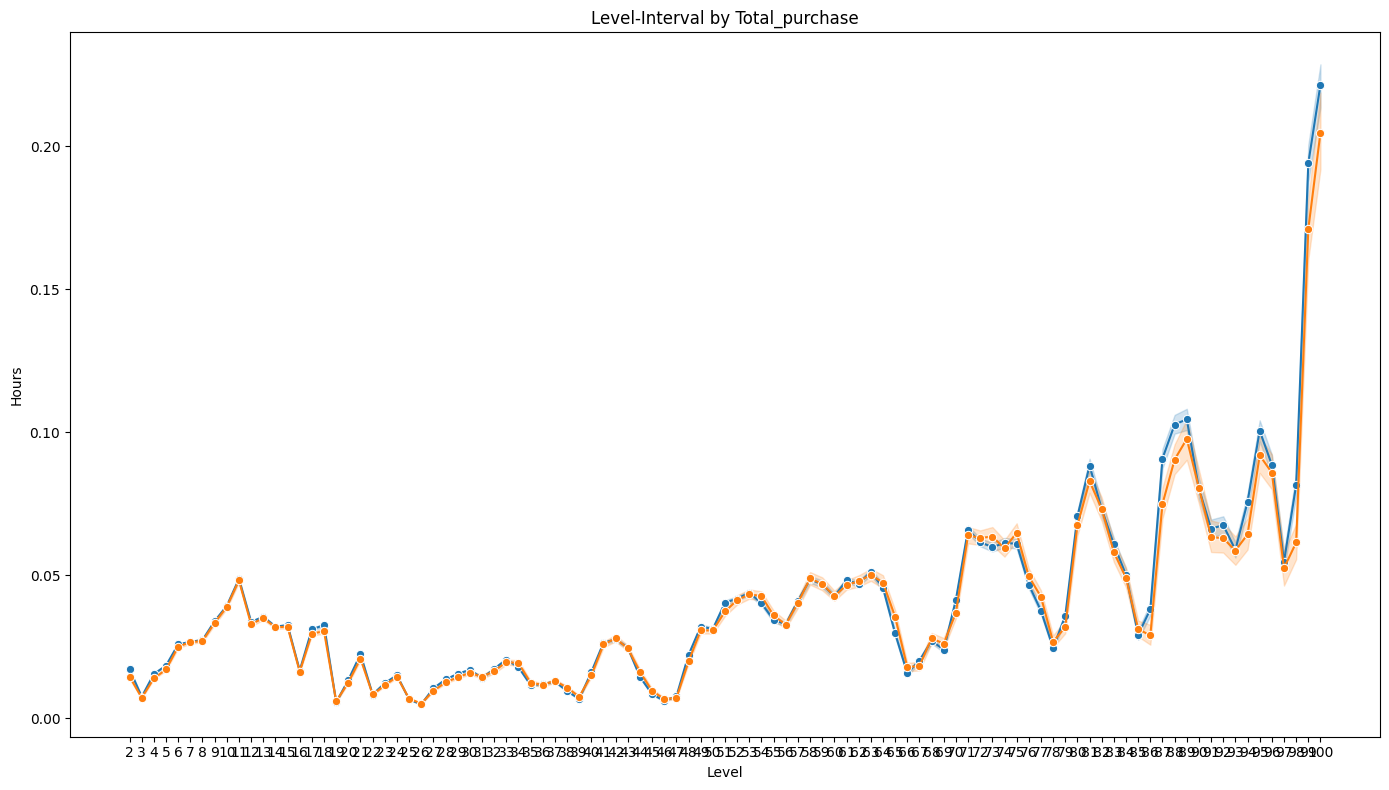

In [6]:
# 플롯 생성
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_data_reset, x='level_to', y='interval', hue='color', marker='o', legend=False)

# 플롯 커스터마이징
plt.title('Level-Interval by Total_purchase')
plt.xlabel('Level')
plt.ylabel('Hours')

# 플롯 표시
plt.tight_layout()
plt.show()

In [159]:
lower_bound = df['total_purchase'].quantile(0.3)
upper_bound = df['total_purchase'].quantile(0.95)

# Filter the DataFrame to remove the top 5% and bottom 5%
df = df[(df['total_purchase'] > 3300) & (df['total_purchase'] < upper_bound)]


In [175]:
df

,player_slug,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,total_purchase
0,2021-11-01T08:32:01.518Z,0.019444,0.004167,0.009444,0.015833,0.015278,0.020833,0.026667,0.034167,0.044722,...,0.069722,0.063056,0.115556,0.152222,0.003333,0.003889,0.132667,0.906944,0.914500,0.0
1,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.045278,0.003889,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,0.0
2,2021-11-01T14:12:34.729Z,0.015833,0.004444,0.030278,0.013889,0.028056,0.020000,0.021389,0.026389,0.032778,...,0.046111,0.051944,0.011667,0.064500,0.351111,0.041611,0.111389,0.002222,0.001944,0.0
3,2021-11-01T15:01:02.831Z,0.007778,0.003056,0.006389,0.009722,0.012500,0.049722,0.070833,0.036222,0.032500,...,0.077222,0.003611,0.043944,0.236111,0.036111,0.002778,0.126667,0.121111,0.135556,0.0
4,2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,...,0.035556,0.129722,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,3300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7274,2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,...,0.060889,0.048611,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,3300.0
7275,2022-03-28T07:44:40.201Z,0.006944,0.003056,0.005833,0.012500,0.012500,0.021667,0.021389,0.027222,0.036944,...,0.127722,0.096944,0.674444,0.759722,0.876389,0.136778,0.171667,0.043056,0.067500,0.0
7276,2022-03-28T11:06:23.113Z,0.006389,0.005278,0.012222,0.021944,0.031389,0.026667,0.024722,0.033889,0.035556,...,0.040778,0.032222,0.020278,0.081389,0.080000,0.002778,0.002778,0.071167,0.149722,122100.0
7277,2022-03-29T09:29:33.653Z,0.031389,0.031111,0.047222,0.029722,0.037778,0.020556,0.023778,0.026111,0.032222,...,0.028611,0.007778,0.046389,0.049167,0.002778,0.002778,0.023444,0.093333,0.102778,0.0


In [176]:
from sklearn.preprocessing import StandardScaler
# total_purchase가 포함된 행만 선택
df = df.drop(columns=['player_slug'])

df = df.dropna(subset=['total_purchase'])

# X (타임라인 데이터)와 y (total_purchase) 분리
y = df['total_purchase'].values
X = df.drop(columns=['total_purchase'])
# 함수형 데이터 객체 생성
argvals = np.arange(X.shape[1])
fd = FDataGrid(data_matrix=X.values, grid_points=argvals)

# 데이터 스케일링 및 B-spline 기반 스무딩
scaler = StandardScaler()
basis = BSplineBasis(n_basis=10)
smoother = BasisSmoother(basis=basis)
fd_smooth = smoother.fit_transform(fd)


In [177]:
# FPCA 적용
fpca = FPCA(n_components=3)
fd_fpca = fpca.fit_transform(fd_smooth)

# 주성분 설명 분산
explained_variance = fpca.explained_variance_ratio_
print("Explained variance ratio by each component:", explained_variance)


Explained variance ratio by each component: [0.84282743 0.13823406 0.01506861]


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_2628\3674483969.py:3: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the functional data object instead.
  plt.plot(argvals, fpca.components_[i].evaluate(argvals)[0], label=f'Principal Component {i+1}')


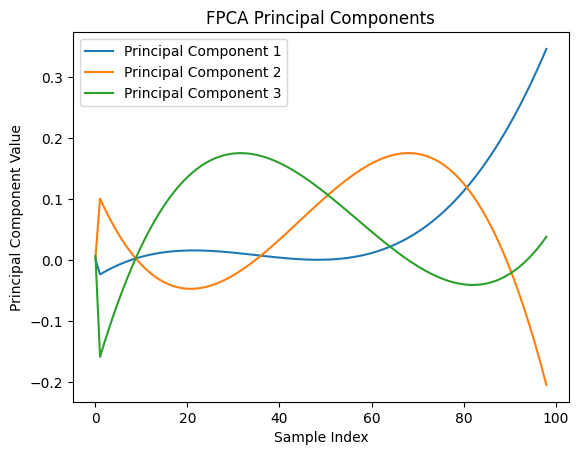

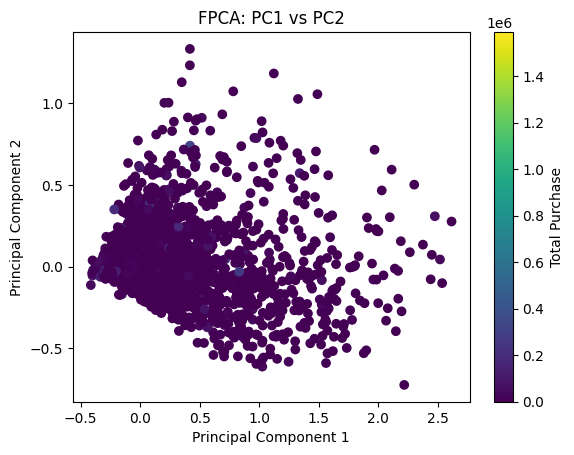

In [178]:
# 주성분 시각화
for i in range(3):
    plt.plot(argvals, fpca.components_[i].evaluate(argvals)[0], label=f'Principal Component {i+1}')

plt.xlabel('Sample Index')
plt.ylabel('Principal Component Value')
plt.title('FPCA Principal Components')
plt.legend()
plt.show()



# 주성분 점수 플롯
plt.scatter(fd_fpca[:, 0], fd_fpca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('FPCA: PC1 vs PC2')
plt.colorbar(label='Total Purchase')
plt.show()


c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


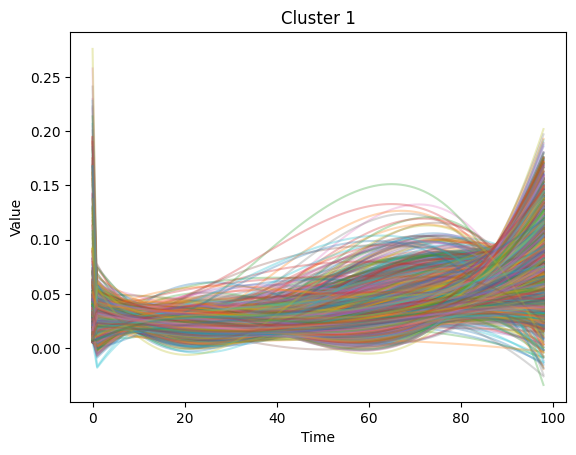

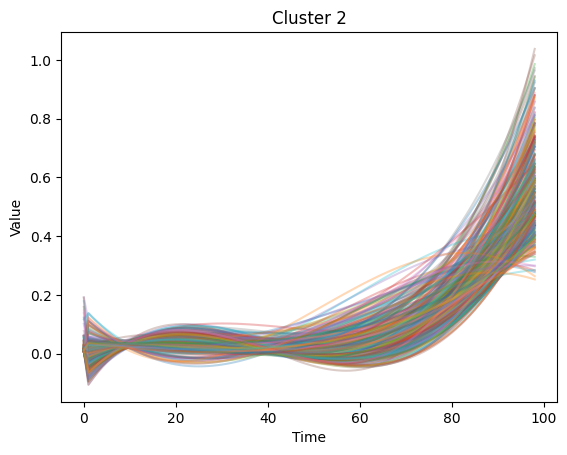

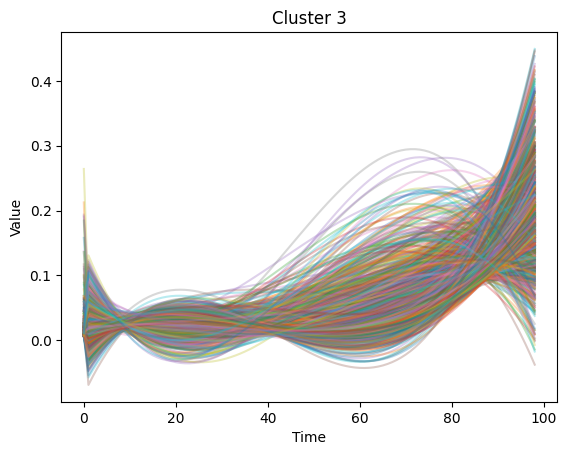

Cluster labels: [2 2 0 ... 0 0 0]


In [179]:

# 함수형 K-평균 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=123)
labels = kmeans.fit_predict(fd_fpca)

# 클러스터링 결과 시각화
for i in range(3):
    cluster_indices = np.where(labels == i)[0]
    plt.figure()
    for index in cluster_indices:
        plt.plot(argvals, fd_smooth.data_matrix[index].flatten(), alpha=0.3)
    plt.title(f'Cluster {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

# 클러스터 할당 결과 확인
print("Cluster labels:", labels)

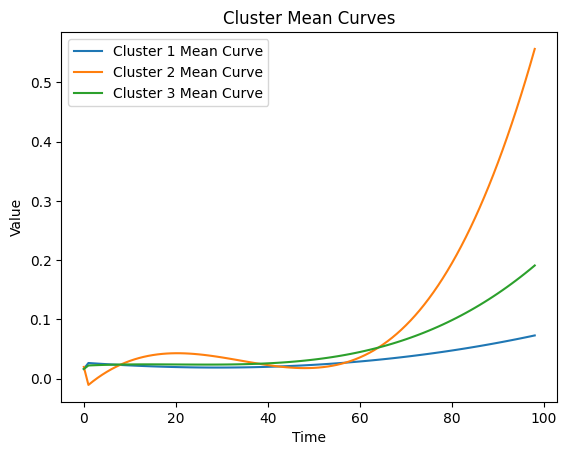

In [180]:
# 클러스터별 평균 곡선 계산 및 시각화
for i in range(3):
    cluster_indices = np.where(labels == i)[0]
    cluster_data = fd_smooth.data_matrix[cluster_indices]
    mean_curve = np.mean(cluster_data, axis=0).flatten()
    plt.plot(argvals, mean_curve, label=f'Cluster {i + 1} Mean Curve')
plt.title('Cluster Mean Curves')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [181]:
# FPCA 주성분을 DataFrame으로 변환
fpca_df = pd.DataFrame(fd_fpca, columns=[f'PC{i+1}' for i in range(fd_fpca.shape[1])])


In [182]:
fpca_df

,PC1,PC2,PC3
0,0.425908,-0.242798,0.072586
1,0.120193,-0.161894,0.002973
2,-0.126732,-0.008908,0.002590
3,-0.085340,-0.025698,0.007323
4,-0.033797,0.093482,0.037043
...,...,...,...
7274,-0.009962,-0.056212,0.040077
7275,0.792481,0.206499,-0.105452
7276,-0.201795,-0.028781,0.011607
7277,-0.239918,-0.030032,-0.027785


In [183]:
# y_test에서 0이 넘는 값의 개수 계산
y_test_positive_count = np.sum(y_test > 0)
print(f'Number of y_test values greater than 0: {y_test_positive_count}')

Number of y_test values greater than 0: 209


In [184]:
y_test

array([13200., 26400., 14300., 20900.,  9900., 23100., 13200.,  9900.,
       36300., 24200., 14300., 13200., 19800.,  9900.,  9900., 13200.,
       34100., 19800.,  9900., 24200., 13200., 14300., 33000., 19800.,
       23100., 24200.,  9900.,  6600., 13200.,  9900., 36300., 33000.,
       13200., 13200., 23100., 23100.,  6600., 29700., 23100., 16500.,
        9900., 19800., 19800., 13200., 13200., 23100., 23100., 36300.,
        9900.,  9900.,  9900., 23100., 13200., 13200.,  9900., 13200.,
       20900., 30800., 24200.,  9900.,  5500., 13200., 13200., 29700.,
        9900., 13200.,  9900.,  9900., 13200., 14300.,  9900., 19800.,
       13200., 13200.,  9900., 24200.,  5500., 33000., 13200., 34100.,
        9900., 14300., 18700., 23100.,  5500., 19800., 23100., 13200.,
       36300., 14300., 24200.,  9900., 13200.,  9900., 33000., 13200.,
       13200., 19800., 13200., 13200., 19800.,  9900.,  9900., 24200.,
       19800., 36300.,  9900.,  9900., 34100.,  9900., 13200., 13200.,
      

In [185]:
y_pred

array([16671.18818039, 16918.15249189, 16829.97856163, 17184.22815909,
       16772.17979131, 16652.68240332, 16564.44531016, 16069.84252859,
       16879.60556532, 17490.39794366, 16356.92515001, 17015.42557668,
       16654.02979994, 17267.53552435, 19100.32796603, 17459.82662386,
       16829.65231558, 17741.92263552, 16771.09972969, 16646.9250515 ,
       16835.89244314, 16792.1838546 , 17161.80491635, 16891.68050993,
       16696.59718019, 17580.92042587, 16892.85514056, 16560.0560482 ,
       17130.34739838, 17174.45743264, 16985.25899296, 16782.16027989,
       17710.62635288, 16848.07737973, 16482.36452066, 16759.11790718,
       16577.29517221, 16385.99420602, 16691.39026002, 15937.3378815 ,
       17689.0686314 , 16679.73623491, 16951.1324498 , 16644.75784085,
       16903.42816607, 16394.52268585, 16864.56640822, 16633.00239185,
       16702.59315902, 19821.93571131, 15721.61832172, 16611.50753719,
       17006.35104303, 17509.59934375, 16759.37600448, 16920.90755593,
      

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              4.547
Date:                Mon, 29 Jul 2024   Prob (F-statistic):                     0.00347
Time:                        14:14:40   Log-Likelihood:                         -7530.2
No. Observations:                5095   AIC:                                  1.507e+04
Df Residuals:                    5092   BIC:                                  1.509e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

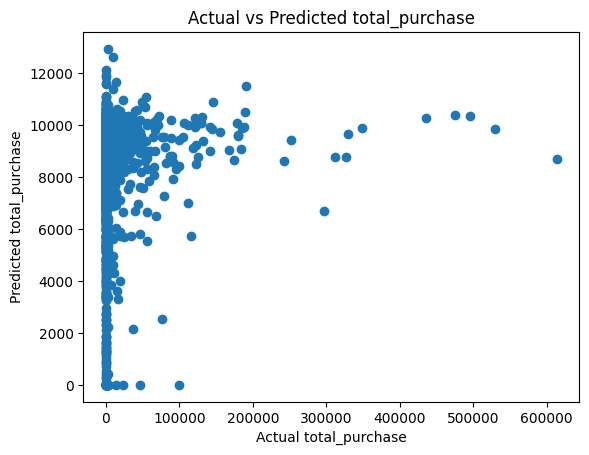

In [187]:
# 데이터 분할 (훈련/테스트)
from sklearn.metrics import r2_score

# total_purchase 값을 기준으로 stratify 배열 생성
#y_stratify = (y > 0).astype(int)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# 데이터 분할 (훈련/테스트)
X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(fd_fpca, y_scaled, test_size=0.3, random_state=110)

# OLS 모델 적합
model = OLS(y_train_scaled, X_train).fit()

# 모델 요약 출력
print(model.summary())


# 테스트 데이터 예측
y_pred_scaled = model.predict(X_test)

# 예측값 역변환
y_pred = y_scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()
y_test = y_scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1)).flatten()
# 예측값이 0보다 작지 않도록 조정
y_pred = np.maximum(y_pred, 0)

# R-squared 값 계산
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')

# 결과 시각화
plt.scatter(y_test, y_pred)
plt.xlabel("Actual total_purchase")
plt.ylabel("Predicted total_purchase")
plt.title("Actual vs Predicted total_purchase")
plt.show()

In [67]:
from sklearn.metrics import r2_score

r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')


R-squared: -0.1272192835431598


Mean Squared Error: 4540127180.116891


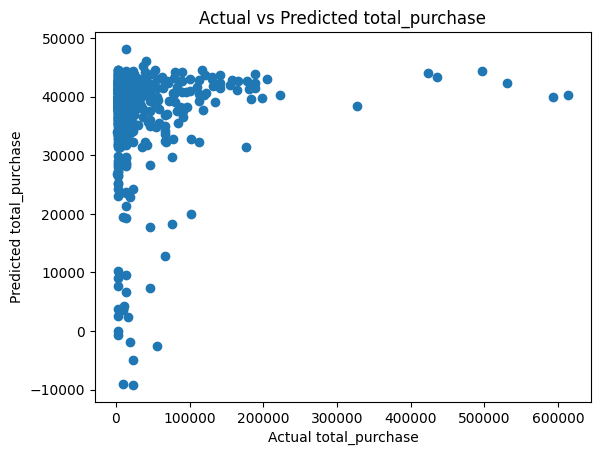

In [22]:
from skfda.ml.regression import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
# 데이터 분할 (훈련/테스트)
y_stratify = (y > 0).astype(int)

# 데이터 분할 (훈련/테스트)
X_train, X_test, y_train, y_test = train_test_split(fd_fpca, y, test_size=0.3, random_state=110, stratify=y_stratify)

# 함수형 부분 최소 제곱 회귀 모델 적합
pls = PLSRegression(n_components=3)
pls.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = pls.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 결과 시각화
plt.scatter(y_test, y_pred)
plt.xlabel("Actual total_purchase")
plt.ylabel("Predicted total_purchase")
plt.title("Actual vs Predicted total_purchase")
plt.show()

In [24]:
X_train

array([[ 3.04045676e-05,  4.56489921e-02,  2.33482806e-03],
       [-3.46083835e-02,  2.16014083e-01, -2.93250715e-02],
       [ 1.56685910e+00, -2.04714983e-01, -9.46158299e-02],
       ...,
       [-1.13762616e-01, -8.50779207e-02,  2.73243025e-02],
       [ 2.13068126e-01, -1.51387434e-02, -1.57748361e-02],
       [-1.33283116e-01, -1.76749633e-02, -1.01353613e-02]])